## Importing Dependencies

In [ ]:
!pip install kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import nltk
from joblib import Parallel, delayed
from nltk.sentiment import SentimentIntensityAnalyzer
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.special import softmax

In [ ]:
# Download the necessary NLTK data

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Fetching the Dataset

In [ ]:
# configuring the path of kaggle.json file

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# API to Fetch dataset from kaggle

!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 98% 79.0M/80.9M [00:03<00:00, 32.5MB/s]
100% 80.9M/80.9M [00:03<00:00, 22.7MB/s]


In [ ]:
# Extracting the compressed Dataset

from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


## Define the columns & Load the dataset

In [ ]:
DATASET_COLUMNS = ['target', 'ids', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

In [ ]:
data.shape

(1600000, 6)

In [ ]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.tail()

,target,ids,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
data.describe()

,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [ ]:
# No missing Values in Dataset

data.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


In [ ]:
print("Unique value counts in the target column:")
print(data['target'].value_counts())

Unique value counts in the target column:
target
0    800000
4    800000
Name: count, dtype: int64


## Data Preprocessing

In [ ]:
def clean_text(text):
    stopwordlist = [
        'a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
        'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before',
        'being', 'below', 'between', 'both', 'by', 'can', 'd', 'did', 'do',
        'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from',
        'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
        'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
        'into', 'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma',
        'me', 'more', 'most', 'my', 'myself', 'needn', 'no', 'nor', 'now',
        'o', 'of', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves',
        'out', 'own', 're', 's', 'same', 'she', "shes", 'should', "shouldve", 'so', 'some', 'such',
        't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
        'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
        'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was',
        'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
        'why', 'will', 'with', 'won', 'y', 'you', "youd", "youll", "youre",
        "youve", 'your', 'yours', 'yourself', 'yourselves'
    ]

    # Function to get NLTK POS tag to WordNet POS tag
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    # Replace @mentions with 'USER'
    text = re.sub(r'@[\S]+', 'USER', text)
    # Remove hashtags but keep the text
    text = re.sub(r'#(\S+)', r'\1', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing whitespace
    text = text.strip()
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stopwordlist])
    # Tokenize text
    tokenizer = RegexpTokenizer(r'\w+|[^\w\s]')
    tokens = tokenizer.tokenize(text)

    # POS tagging
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize each token with the appropriate POS tag
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]

    return " ".join(lemmatized_tokens)


In [ ]:
# Preprocess the text data
data['text'] = data['text'].apply(clean_text)

# Ensure equal number of positive and negative samples
positive_samples = data[data['target'] == 4].sample(10000, random_state=42)
negative_samples = data[data['target'] == 0].sample(10000, random_state=42)
data_subset = pd.concat([positive_samples, negative_samples])

# Replace target values
data_subset['target'] = data_subset['target'].replace(4, 1)

In [ ]:
data_subset.head()

,target,ids,date,flag,user,text
1012188,1,1881179620,Fri May 22 03:51:54 PDT 2009,NO_QUERY,tarawade,lookin ward long weekend really dont want go w...
1099036,1,1970537555,Sat May 30 04:15:49 PDT 2009,NO_QUERY,Millie_stillie,myweakness music live meet people make
1275978,1,2001154935,Tue Jun 02 00:00:21 PDT 2009,NO_QUERY,zsangel,figure internet new ipod
1388988,1,2053074174,Sat Jun 06 03:10:08 PDT 2009,NO_QUERY,krisignacio,USER can ' t wait worship guy tonight . it ' l...
938859,1,1793548492,Thu May 14 03:06:55 PDT 2009,NO_QUERY,_DrInE_,USER congrats james ! ! i ' m sure book go hug...


In [ ]:
# # Save the DataFrame to an Excel file
# # Save a subset or chunk of the DataFrame
# chunk_size = 1000000
# for i in range(0, len(data), chunk_size):
#     chunk = data.iloc[i: i + chunk_size]
#     chunk.to_excel(f'preprocessed_tweet_data_part_{i // chunk_size}.xlsx', index=False)

In [ ]:
# import pandas as pd

# # Read the two Excel files
# ptd1 = pd.read_excel('preprocessed_tweet_data_part_0.xlsx')
# ptd2 = pd.read_excel('preprocessed_tweet_data_part_1.xlsx')

# # Concatenate the DataFrames
# combined_df = pd.concat([ptd1, ptd2])

# # Save the combined DataFrame to a new Excel file
# combined_df.to_csv('combined_preprocessed_tweet_data.csv', index=False)

## Load the model and tokenizer

In [ ]:
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to predict sentiment
def predict_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output[0][0].cpu().numpy()
    scores = softmax(scores)
    # Ignore neutral class
    negative_score = scores[0]
    positive_score = scores[2]
    return 1 if positive_score > negative_score else 0
#    return "Positive_Score",positive_score if positive_score > negative_score else "Negative Score",negative_score

# Apply sentiment prediction
data_subset['sentiment'] = data_subset['text'].apply(predict_sentiment)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
data_subset

,target,ids,date,flag,user,text,sentiment
1012188,1,1881179620,Fri May 22 03:51:54 PDT 2009,NO_QUERY,tarawade,lookin ward long weekend really dont want go w...,0
1099036,1,1970537555,Sat May 30 04:15:49 PDT 2009,NO_QUERY,Millie_stillie,myweakness music live meet people make,0
1275978,1,2001154935,Tue Jun 02 00:00:21 PDT 2009,NO_QUERY,zsangel,figure internet new ipod,1
1388988,1,2053074174,Sat Jun 06 03:10:08 PDT 2009,NO_QUERY,krisignacio,USER can ' t wait worship guy tonight . it ' l...,1
938859,1,1793548492,Thu May 14 03:06:55 PDT 2009,NO_QUERY,_DrInE_,USER congrats james ! ! i ' m sure book go hug...,1
...,...,...,...,...,...,...,...
769641,0,2301524879,Tue Jun 23 15:33:26 PDT 2009,NO_QUERY,carlyfrank,hmm spent hour emma yesterday couple sarah tod...,0
203328,0,1972337573,Sat May 30 09:02:12 PDT 2009,NO_QUERY,Frau_B,not like heat . think bitten can ' t stop snee...,0
20489,0,1557080836,Sun Apr 19 01:54:31 PDT 2009,NO_QUERY,cazzy4k,"USER yes shame , sutil usually good wet",1
152485,0,1932750659,Tue May 26 22:08:04 PDT 2009,NO_QUERY,wendykind,"oh man read tweet jon kate , guy right , tragi...",0


In [ ]:

# Evaluation
y_true = data_subset['target']
y_pred = data_subset['sentiment']
report = classification_report(y_true, y_pred, target_names=["negative", "positive"])

print(report)

              precision    recall  f1-score   support

    negative       0.75      0.71      0.73       500
    positive       0.72      0.76      0.74       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



## Testing on a single tweet

In [ ]:
def test_single_tweet(tweet):
    tweet = clean_text(tweet)
    sentiment = predict_sentiment(tweet)
    return "positive" if sentiment == 1 else "negative"   # return sentiment, score

# Test the model with a single tweet
test_tweet = "I want to pursue my carrer in data_science #Datascience"

predicted_sentiment = test_single_tweet(test_tweet)
print(f"The sentiment of the tweet '{test_tweet}' is {predicted_sentiment}.")

The sentiment of the tweet 'I want to pursue my carrer in data_science #Datascience' is positive.


> Achieving a **74% accuracy** in sentiment analysis is a good starting point, but there are several strategies you can employ to improve the performance further.

Here are some actionable steps to consider:

## 1. Fine-Tuning the Model

### Fine-Tune on Your Dataset
Fine-tuning the pre-trained model on your specific dataset can significantly improve performance. Here’s a brief outline of how to do that:

- **Prepare Your Data**: Ensure your data is in the correct format for training. You should have a labeled dataset with text and corresponding sentiment labels.

- **Set Up Training**: Use the `Trainer` API from the Hugging Face Transformers library to fine-tune the model.

## 2. Data Augmentation

### Augment Your Dataset
Consider augmenting your dataset to introduce more variability. Techniques include:

- **Synonym Replacement**: Replace words with their synonyms.
- **Back Translation**: Translate the text to another language and back to the original language.
- **Random Insertion/Deletion**: Randomly insert or delete words in the text.

## 3. Hyperparameter Tuning

### Experiment with Hyperparameters
Adjusting hyperparameters can lead to better performance. Key hyperparameters to tune include:

- **Learning Rate**: Experiment with different learning rates (e.g., 1e-5, 2e-5, 5e-5).
- **Batch Size**: Test different batch sizes (e.g., 8, 16, 32).
- **Number of Epochs**: Increase the number of training epochs while monitoring for overfitting.

You can use libraries like Optuna or Ray Tune for automated hyperparameter tuning.

## 4. Advanced Model Architectures

### Try Different Models
Experiment with different transformer architectures. Some options include:

- **BERT**: A widely used model for various NLP tasks.
- **DistilBERT**: A smaller, faster, and lighter version of BERT.
- **XLNet**: A generalized autoregressive pretraining model that can capture bidirectional context.

## 5. Ensemble Methods

### Combine Multiple Models
Using an ensemble of models can improve performance. Train multiple models and average their predictions or use a voting mechanism.

## 6. Error Analysis

### Analyze Misclassifications
Perform a detailed error analysis to understand where the model is failing. Look for patterns in misclassified examples and consider:

- **Domain-Specific Issues**: Are there specific terms or phrases that the model struggles with?
- **Sentiment Ambiguity**: Are there instances where the sentiment is ambiguous or context-dependent?

## 7. Use Class Weights

### Handle Class Imbalance
If your dataset is imbalanced (e.g., significantly more negative than positive samples), consider using class weights during training to give more importance to the minority class.

```python
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=[0, 4], y=data_subset['target'])
```

## 8. Continuous Learning

### Implement Continuous Learning
If you have a stream of incoming data, consider implementing a continuous learning approach where the model is periodically retrained on new data.

## Conclusion

By implementing these strategies, you should be able to improve the accuracy of your sentiment analysis model beyond 74%. Remember that model improvement is often an iterative process, so keep experimenting, analyzing results, and refining your approach. Good luck, and let me know if you have any questions about specific steps!

## **Fine-Tuning the Model**


> To improve Accuracy




**Data Splitting:**


*   Split the dataset into **training (64%)**, **validation (16%)**, and **test (20%)** sets using ***train_test_split***.


* The ***stratify*** parameter ensures that the distribution of labels is maintained in each split.

**Compute Metrics Function:** The compute_metrics function calculates the accuracy. It takes the predictions and labels, computes the predicted classes using torch.argmax, and then uses accuracy_score from sklearn to calculate accuracy.

**Passing the Metric Function:** The compute_metrics function is passed to the Trainer, which will call it during evaluation.

**Accessing the Accuracy:** The accuracy is now stored under the key 'eval_accuracy', which you can access after evaluation.

In [ ]:
# Fine-Tuning

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.nn.functional import softmax

# Load the dataset
data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Split the dataset into training, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_subset['text'],
    data_subset['target'],
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=data_subset['target']  # Stratify to maintain label distribution
)

# Further split the training set into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,  # 20% of the training set for validation
    random_state=42,
    stratify=train_labels
)

# Function to encode the dataset
def encode_dataset(texts, labels):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128)
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask'], 'labels': labels.tolist()}

# Encode datasets
train_encodings = encode_dataset(train_texts, train_labels)
val_encodings = encode_dataset(val_texts, val_labels)
test_encodings = encode_dataset(test_texts, test_labels)

# Create a dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        self.labels = encodings['labels']

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SentimentDataset(train_encodings)
val_dataset = SentimentDataset(val_encodings)
test_dataset = SentimentDataset(test_encodings)

# Define a compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",      # evaluate every epoch
)

# Create the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics      # compute metrics function
)


# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.550000,0.497742,0.806250
2,0.539100,0.467375,0.800000
3,0.322000,0.581256,0.787500


TrainOutput(global_step=240, training_loss=0.5408757671713829, metrics={'train_runtime': 1347.1981, 'train_samples_per_second': 1.425, 'train_steps_per_second': 0.178, 'total_flos': 53280467089920.0, 'train_loss': 0.5408757671713829, 'epoch': 3.0})

In [ ]:
# Evaluate the model on the test set

test_results = trainer.evaluate(test_dataset)
print(f"Test Accuracy: {test_results['eval_accuracy']:.2f}")

Test Accuracy: 0.76


# Sentiment Trends Over Time

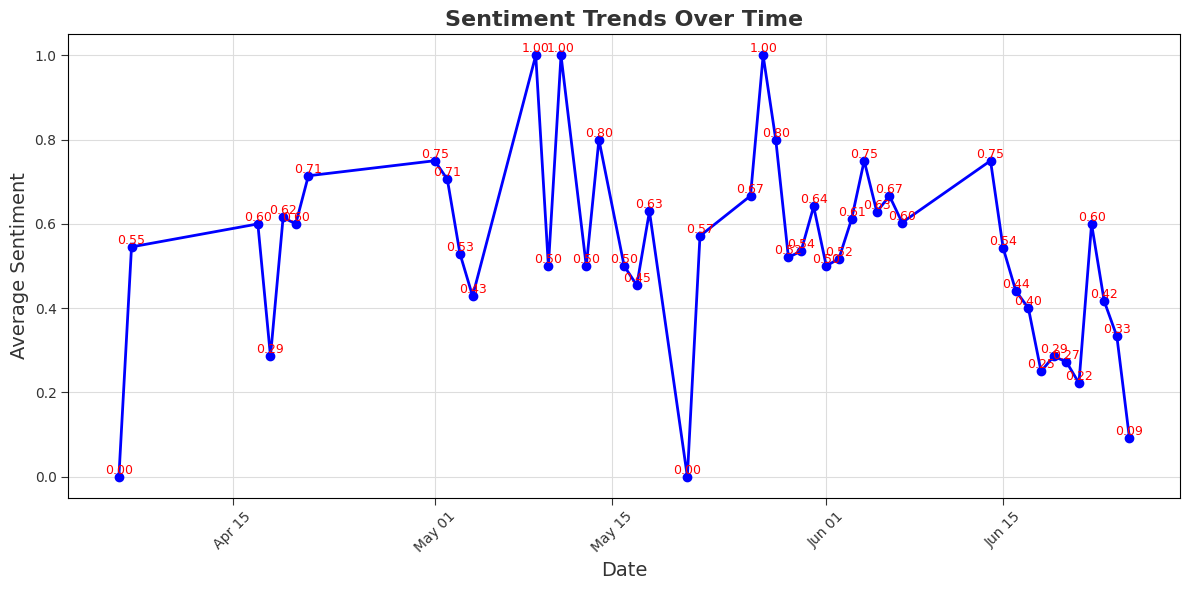

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert date column to datetime format (if not already)
data_subset['date'] = pd.to_datetime(data_subset['date'], errors='coerce')

# Group by date and calculate the average sentiment per day
sentiment_trends = data_subset.groupby(data_subset['date'].dt.date)['sentiment'].mean()

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trends.index, sentiment_trends.values, marker='o', linestyle='-', color='b', linewidth=2)

# Add labels to each point
for i, value in enumerate(sentiment_trends.values):
    plt.text(sentiment_trends.index[i], value, f'{value:.2f}', fontsize=9, ha='center', va='bottom', color='r')

# Set x-axis date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.title('Sentiment Trends Over Time', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Date', fontsize=14, color='#333333')
plt.ylabel('Average Sentiment', fontsize=14, color='#333333')
plt.xticks(rotation=45, fontsize=10, color='#333333')  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10, color='#333333')
plt.grid(True, color='#DDDDDD')
plt.tick_params(axis='both', which='major', length=5, color='#333333')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

On April 06, 2009, the sentiment was 0.00 (Neutral).
On April 07, 2009, the sentiment was 0.55 (Positive).
On April 17, 2009, the sentiment was 0.60 (Positive).
On April 18, 2009, the sentiment was 0.29 (Positive).
On April 19, 2009, the sentiment was 0.62 (Positive).
On April 20, 2009, the sentiment was 0.60 (Positive).
On April 21, 2009, the sentiment was 0.71 (Positive).
On May 01, 2009, the sentiment was 0.75 (Positive).
On May 02, 2009, the sentiment was 0.71 (Positive).
On May 03, 2009, the sentiment was 0.53 (Positive).
On May 04, 2009, the sentiment was 0.43 (Positive).
On May 09, 2009, the sentiment was 1.00 (Positive).
On May 10, 2009, the sentiment was 0.50 (Positive).
On May 11, 2009, the sentiment was 1.00 (Positive).
On May 13, 2009, the sentiment was 0.50 (Positive).
On May 14, 2009, the sentiment was 0.80 (Positive).
On May 16, 2009, the sentiment was 0.50 (Positive).
On May 17, 2009, the sentiment was 0.45 (Positive).
On May 18, 2009, the sentiment was 0.63 (Positive).

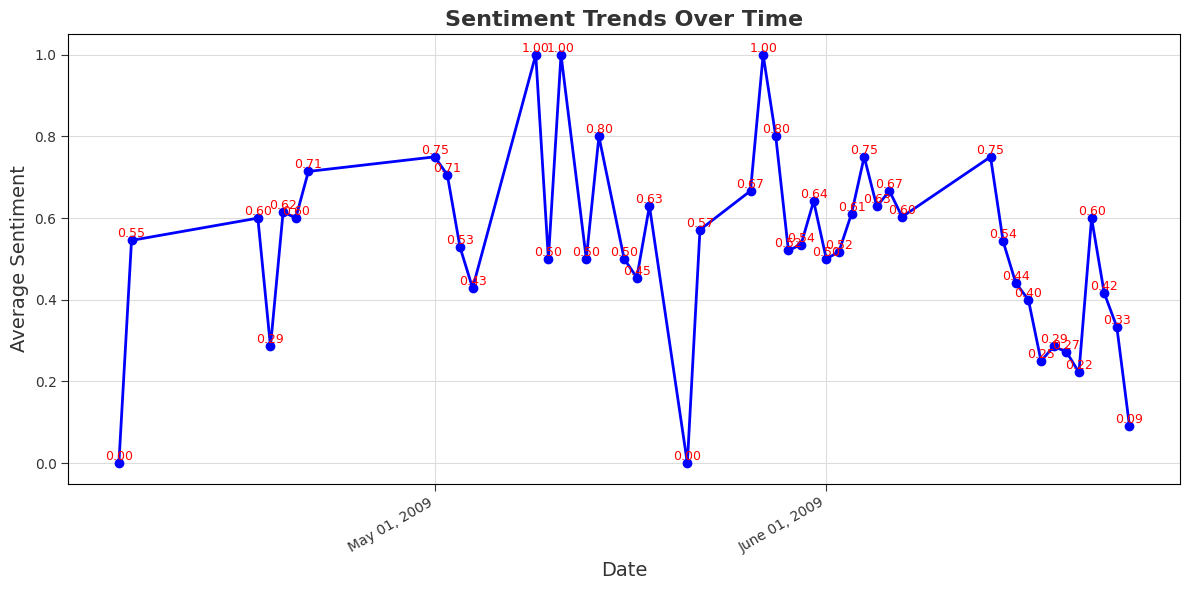

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert date column to datetime format (if not already)
data_subset['date'] = pd.to_datetime(data_subset['date'], errors='coerce')

# Group by date and calculate the average sentiment per day
sentiment_trends = data_subset.groupby(data_subset['date'].dt.date)['sentiment'].mean()

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trends.index, sentiment_trends.values, marker='o', linestyle='-', color='b', linewidth=2)

# Add labels to each point
for i, value in enumerate(sentiment_trends.values):
    plt.text(sentiment_trends.index[i], value, f'{value:.2f}', fontsize=9, ha='center', va='bottom', color='r')

# Set x-axis date format to "Month Day, Year"
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %d, %Y'))

# Improve date ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to every month
plt.gcf().autofmt_xdate()  # Auto format x-axis dates for better readability

plt.title('Sentiment Trends Over Time', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Date', fontsize=14, color='#333333')
plt.ylabel('Average Sentiment', fontsize=14, color='#333333')
plt.xticks(fontsize=10, color='#333333')  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10, color='#333333')
plt.grid(True, color='#DDDDDD')
plt.tick_params(axis='both', which='major', length=5, color='#333333')
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Print insights for each interval
for date, sentiment in sentiment_trends.items():
    if sentiment > 0:
        sentiment_label = 'Positive'
    elif sentiment < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    print(f"On {date.strftime('%B %d, %Y')}, the sentiment was {sentiment:.2f} ({sentiment_label}).")

plt.show()

# Tweet Volume Patterns

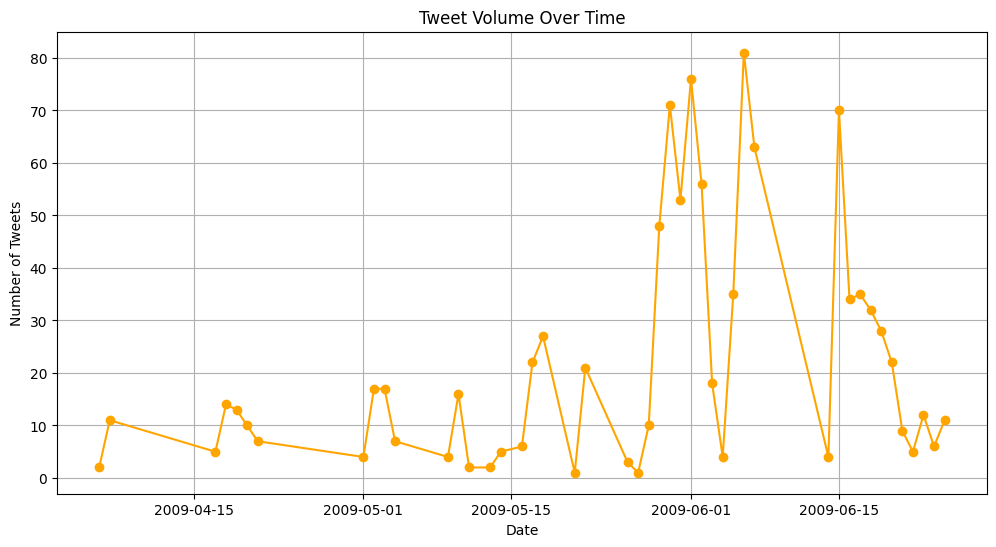

In [ ]:
# Group by date and count the number of tweets per day
tweet_volume = data_subset.groupby(data_subset['date'].dt.date)['text'].count()

# Plot tweet volume over time
plt.figure(figsize=(12, 6))
plt.plot(tweet_volume, marker='o', color='orange')
plt.title('Tweet Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()


Total Tweets for Each Month:
April 2009: 62 tweets
May 2009: 337 tweets
June 2009: 601 tweets


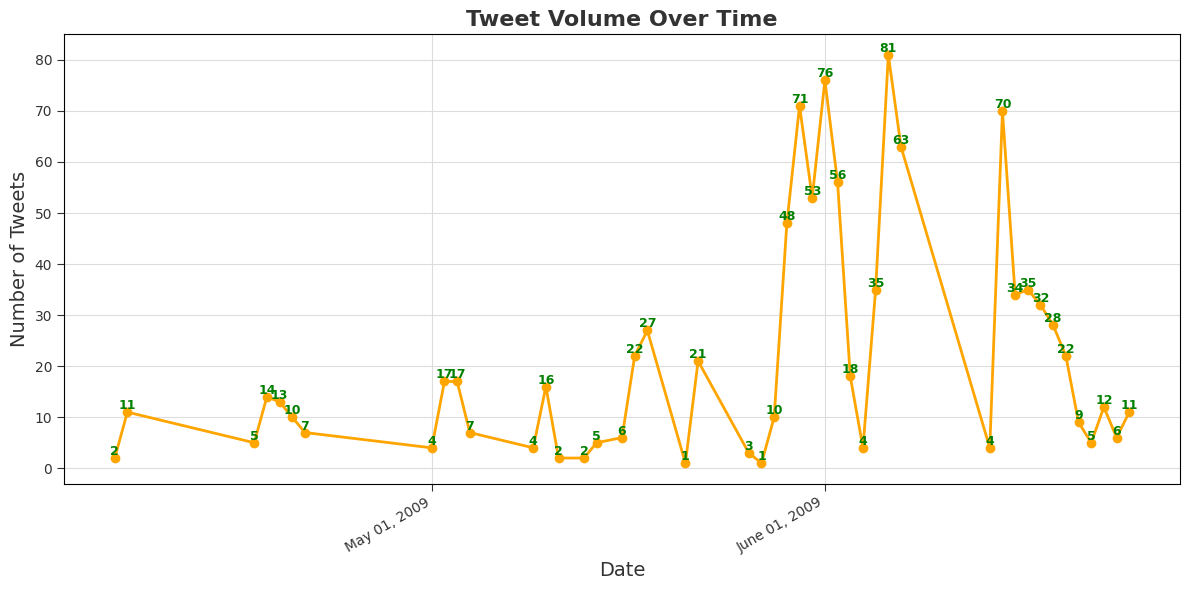

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert date column to datetime format (if not already)
data_subset['date'] = pd.to_datetime(data_subset['date'], errors='coerce')

# Group by date and count the number of tweets per day
tweet_volume = data_subset.groupby(data_subset['date'].dt.date)['text'].count()

# Plot tweet volume over time
plt.figure(figsize=(12, 6))
plt.plot(tweet_volume.index, tweet_volume.values, marker='o', color='orange', linewidth=2)

# Add labels to each point with bold font
for i, value in enumerate(tweet_volume.values):
    plt.text(tweet_volume.index[i], value, f'{value}', fontsize=9, ha='center', va='bottom', color='green', fontweight='bold')

# Set x-axis date format to "Month Day, Year"
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B %d, %Y'))

# Set major ticks to show the first of each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at the start of each month
plt.gcf().autofmt_xdate()  # Auto format x-axis dates for better readability

plt.title('Tweet Volume Over Time', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Date', fontsize=14, color='#333333')
plt.ylabel('Number of Tweets', fontsize=14, color='#333333')
plt.xticks(fontsize=10, color='#333333')  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10, color='#333333')
plt.grid(True, color='#DDDDDD')
plt.tick_params(axis='both', which='major', length=5, color='#333333')
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Calculate total tweets per month
monthly_tweet_volume = data_subset.resample('M', on='date')['text'].count()

# Print total tweets for each month
print("Total Tweets for Each Month:")
for month, total in monthly_tweet_volume.items():
    print(f"{month.strftime('%B %Y')}: {total} tweets")

plt.show()

# Tweet Activity Over Time

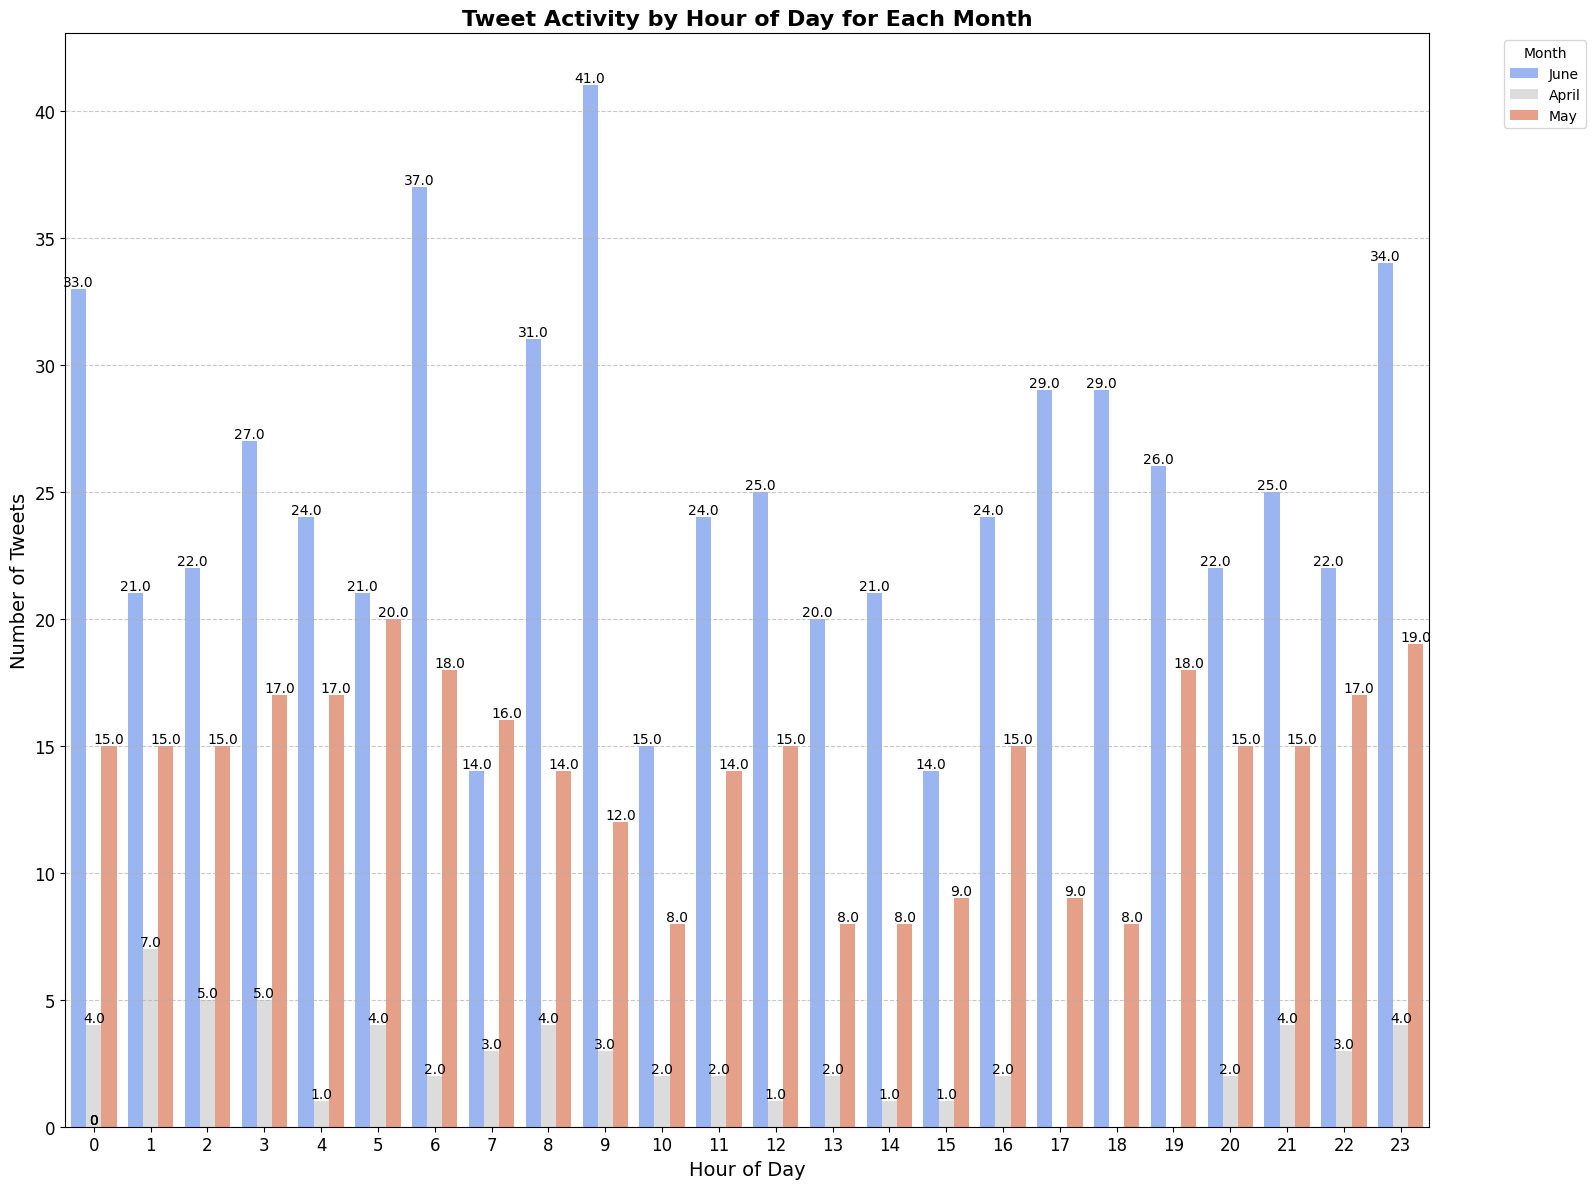

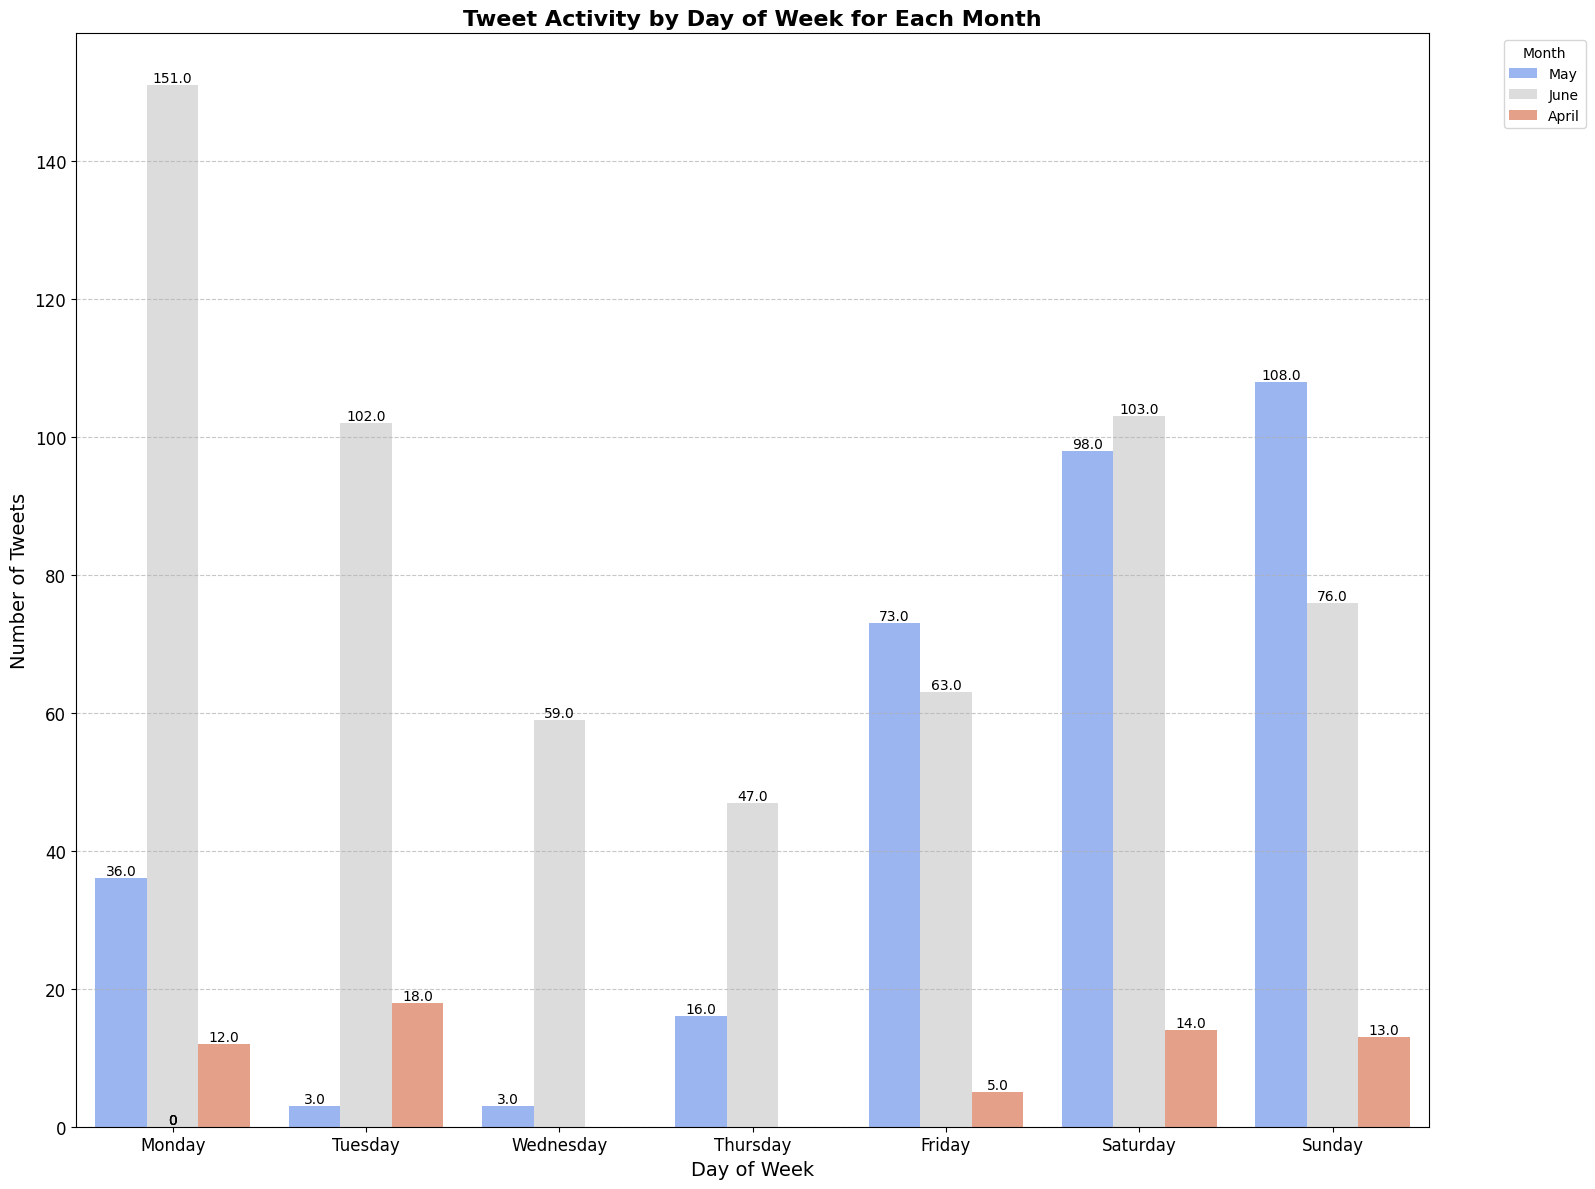

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data creation (for demonstration purposes)
# data_subset = pd.DataFrame({
#     'date': pd.date_range(start='2023-01-01', periods=1000, freq='H'),
#     'text': ['Tweet #{}'.format(i) for i in range(1000)]
# })

# Extract hour of the day and day of the week from the datetime
data_subset['date'] = pd.to_datetime(data_subset['date'], errors='coerce')  # Ensure 'date' is in datetime format
data_subset['hour'] = data_subset['date'].dt.hour
data_subset['day_of_week'] = data_subset['date'].dt.day_name()
data_subset['month'] = data_subset['date'].dt.strftime('%B')  # Extract month name

# Set the order of months for consistent plotting
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Plot tweet activity by hour for each month
plt.figure(figsize=(16, 12))
ax = sns.countplot(x='hour', data=data_subset, palette='coolwarm', hue='month', order=range(24))
plt.title('Tweet Activity by Hour of Day for Each Month', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add month labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Plot tweet activity by day of the week for each month
plt.figure(figsize=(16, 12))
ax2 = sns.countplot(x='day_of_week', data=data_subset,
                    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                    palette='coolwarm', hue='month')
plt.title('Tweet Activity by Day of Week for Each Month', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add month labels above the bars
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# Combining Sentiment with Tweet Volume

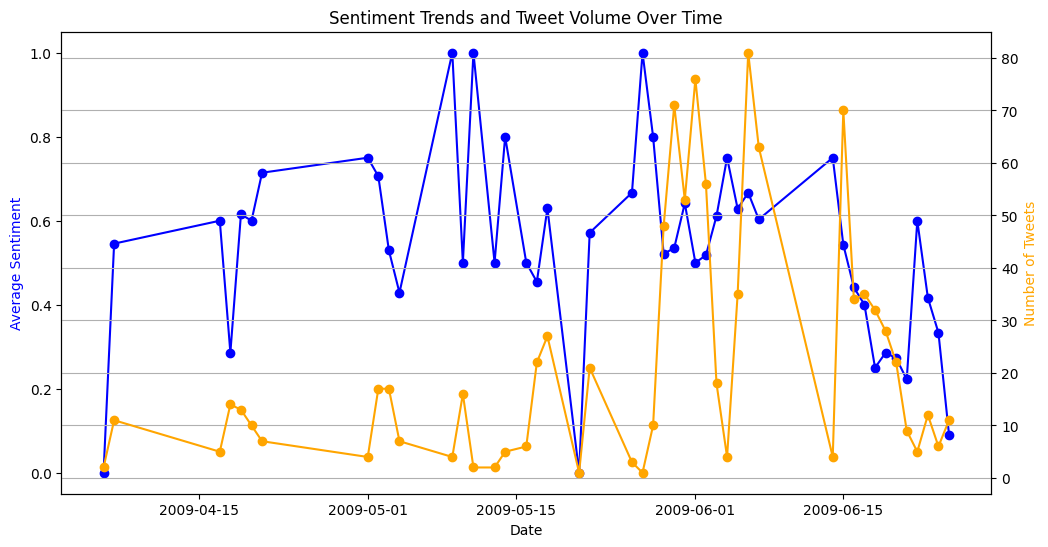

In [ ]:
# Plot sentiment trends and tweet volume on the same plot
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(sentiment_trends, marker='o', color='blue', label='Sentiment')
ax2.plot(tweet_volume, marker='o', color='orange', label='Tweet Volume')

ax1.set_xlabel('Date')
ax1.set_ylabel('Average Sentiment', color='blue')
ax2.set_ylabel('Number of Tweets', color='orange')

plt.title('Sentiment Trends and Tweet Volume Over Time')
plt.grid(True)
plt.show()


[Text(0, 1, 'Positive'), Text(1, 1, 'Positive'), Text(2, 1, 'Positive')]

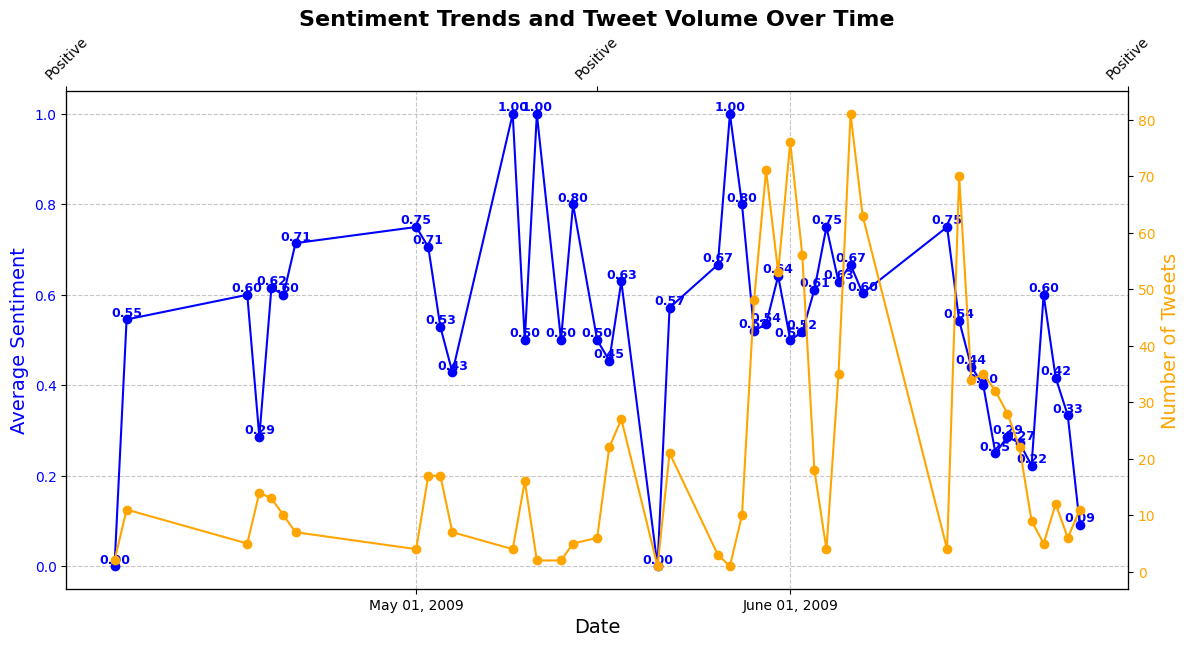

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter


# Convert date column to datetime format (if not already)
data_subset['date'] = pd.to_datetime(data_subset['date'], errors='coerce')

# Group by date and calculate the average sentiment per day
sentiment_trends = data_subset.groupby(data_subset['date'].dt.date)['sentiment'].mean()

# Group by date and count the number of tweets per day
tweet_volume = data_subset.groupby(data_subset['date'].dt.date)['text'].count()

# Plot sentiment trends and tweet volume on the same plot
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot sentiment trends
ax1.plot(sentiment_trends.index, sentiment_trends.values, marker='o', color='blue', label='Sentiment')

# Add labels to each point with bold font
for i, value in enumerate(sentiment_trends.values):
    ax1.text(sentiment_trends.index[i], value, f'{value:.2f}', fontsize=9, ha='center', va='bottom', color='blue', fontweight='bold')

ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Average Sentiment', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Sentiment Trends and Tweet Volume Over Time', fontsize=16, fontweight='bold')

# Plot tweet volume
ax2.plot(tweet_volume.index, tweet_volume.values, marker='o', color='orange', label='Tweet Volume')
ax2.set_ylabel('Number of Tweets', color='orange', fontsize=14)
ax2.tick_params(axis='y', labelcolor='orange')

# Formatting the x-axis to show only the first day of each month
ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at the start of each month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%B %d, %Y'))  # Format for the x-axis
plt.xticks(rotation=45, fontsize=10)  # Slanting x-axis labels

# Add gridlines
ax1.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
# plt.show() # Commenting this out for now to add the monthly sentiment

# Calculate total tweets per month
monthly_tweet_volume = data_subset.resample('M', on='date')['text'].count()

# Calculate average sentiment per month
monthly_sentiment = data_subset.resample('M', on='date')['sentiment'].mean()

# Determine sentiment label for each month
sentiment_labels = []
for sentiment in monthly_sentiment:
    if sentiment > 0:
        sentiment_labels.append('Positive')
    elif sentiment < 0:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')

# Create a second x-axis for monthly sentiment
ax3 = ax1.twiny()

# Set the positions of the x-ticks to match the months
month_positions = range(len(monthly_sentiment))
ax3.set_xticks(month_positions)
# Set the labels to be the sentiment labels
ax3.set_xticklabels(sentiment_labels, rotation=45)

# Total Users

In [ ]:
# Find the total number of unique users
total_users = data['user'].nunique()

print(f"Total number of unique users: {total_users}")


Total number of unique users: 659775


# Active Users


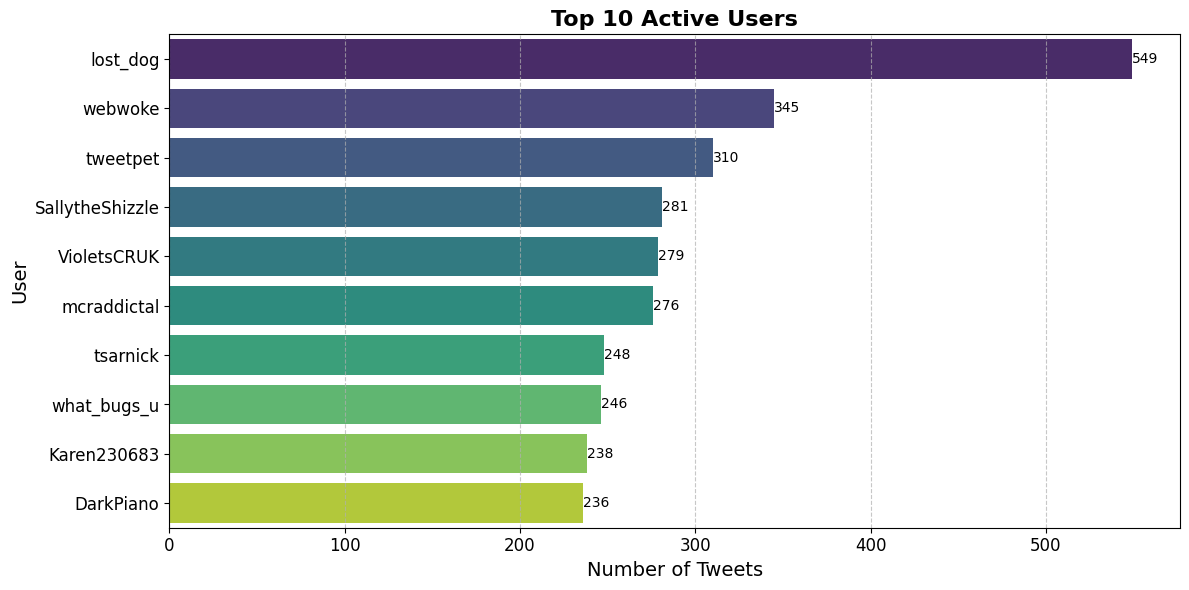

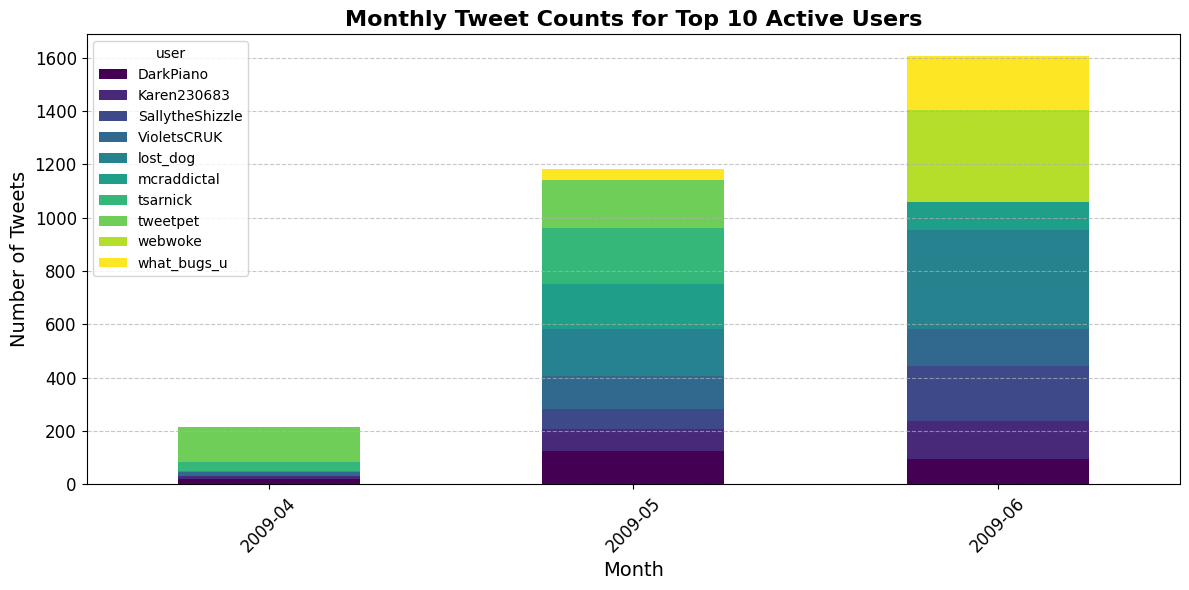

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Find the top 10 active users
top_users = data['user'].value_counts().head(10)

# Plot the top 10 active users
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_users.values, y=top_users.index, hue=top_users.index, palette='viridis', legend=False)
plt.title('Top 10 Active Users', fontsize=16, fontweight='bold')
plt.xlabel('Number of Tweets', fontsize=14)
plt.ylabel('User', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add labels to each bar
for i, count in enumerate(top_users.values):
    ax.text(count, i, str(count), va='center', ha='left', fontsize=10, color='black')

plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Create a DataFrame for the top users
top_users_list = top_users.index.tolist()

# Convert 'date' column to datetime, handling timezones
if not pd.api.types.is_datetime64_any_dtype(data['date']):
    # Remove unrecognized timezones before conversion
    data['date'] = data['date'].str.replace(r'\b(PDT|PST|EDT|EST|CDT|CST|MDT|MST)\b', '', regex=True)
    data['date'] = pd.to_datetime(data['date'], errors='coerce')

    # If you want to preserve timezone information, use tz_localize:
    # data['date'] = data['date'].dt.tz_localize('America/Los_Angeles') # Example, adjust as needed

# Extract month from the 'date' column
data['month'] = data['date'].dt.to_period('M')  # Extract month

# Count tweets per month for top users
monthly_tweets = data[data['user'].isin(top_users_list)].groupby(['month', 'user']).size().unstack(fill_value=0)

# Plot the number of tweets per month for top users
plt.figure(figsize=(12, 6))
monthly_tweets.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Monthly Tweet Counts for Top 10 Active Users', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


### Summary of Results

- **Epoch 1**:
  - Training Loss: **0.022000**
  - Validation Loss: **0.993111**
  - Accuracy: **0.818750** (81.88%)

- **Epoch 2**:
  - Training Loss: **0.106000**
  - Validation Loss: **1.131577**
  - Accuracy: **0.812500** (81.25%)

- **Epoch 3**:
  - Training Loss: **0.067700**
  - Validation Loss: **1.526893**
  - Accuracy: **0.806250** (80.63%)

### Analysis

1. **Training Loss**:
   - The training loss decreases from Epoch 1 to Epoch 3, which generally indicates that the model is learning from the training data. A lower training loss suggests that the model is fitting the training data better.

2. **Validation Loss**:
   - The validation loss initially decreases from Epoch 1 to Epoch 2 but then increases in Epoch 3. This pattern can indicate that the model is starting to overfit the training data. Overfitting occurs when the model learns the training data too well, including its noise and outliers, which can negatively impact its performance on unseen data.

3. **Accuracy**:
   - The accuracy on the validation set shows a slight decrease from Epoch 1 to Epoch 3. This is concerning because it suggests that, despite the training loss decreasing, the model's ability to generalize to the validation set is diminishing.

### Conclusions

- **Overfitting**: The increase in validation loss and the decrease in validation accuracy after the first epoch suggest that the model may be overfitting. This is a common issue where the model performs well on training data but poorly on validation data.

### Recommendations

1. **Early Stopping**: Implement early stopping to halt training when the validation loss starts to increase. This helps in preserving the model's performance before it starts overfitting.

2. **Regularization**: Consider using techniques like dropout layers or L2 regularization to help mitigate overfitting.

3. **Reduce Epochs**: Since the validation performance is starting to decline, you might want to reduce the number of epochs further or monitor closely to find the optimal stopping point.

4. **Learning Rate Adjustment**: Experiment with different learning rates. A learning rate that is too high may cause the model to converge too quickly to a suboptimal solution, while a very low learning rate may lead to slow convergence.

5. **Data Augmentation**: If you have a limited dataset, consider augmenting it to provide more diverse training examples, which can help improve generalization.

6. **Hyperparameter Tuning**: Experiment with different batch sizes, learning rates, and other hyperparameters to find the best configuration for your model.

7. **Analyze Misclassifications**: Look at the examples that are being misclassified to understand if there are specific patterns or classes that the model struggles with. This can provide insights into how to improve the dataset or model architecture.

By taking these steps, you can work towards improving the model's performance and ensuring it generalizes better to unseen data. If you have any further questions or need assistance with specific strategies, feel free to ask!

If your model's accuracy decreased after fine-tuning, it's possible that you may have encountered overfitting or the fine-tuning process did not generalize well to the test set. Here are a few things you can try to improve the performance:

1. **Increase the Size of the Training Set**: If possible, try to gather more labeled data for training. A larger dataset can help the model learn better representations and generalize more effectively.

2. **Reduce the Number of Fine-Tuning Epochs**: You may be overfitting to the training data after too many epochs. Try reducing the number of epochs and monitor the validation set performance to find the optimal number.

3. **Introduce Regularization**: Add regularization techniques to your model to prevent overfitting, such as:
   - **Dropout**: Randomly drop out a fraction of the neurons during training to reduce overfitting.
   - **L1/L2 Regularization**: Add a penalty term to the loss function based on the magnitude of the weights.
   - **Early Stopping**: Stop the training process when the validation set performance stops improving.

4. **Adjust the Learning Rate**: Experiment with different learning rates during fine-tuning. A lower learning rate may help the model converge more smoothly and avoid overfitting.

5. **Increase the Validation Set Size**: If your validation set is too small, the model may overfit to it. Try increasing the size of the validation set to get a more reliable estimate of the model's performance.

6. **Perform Data Augmentation**: Generate additional training examples by applying transformations like synonym replacement, back-translation, or random insertion/deletion. This can help the model learn more robust representations.

7. **Try Different Model Architectures**: Experiment with other pre-trained models or fine-tune the model for a different number of layers. Different architectures may perform better depending on your dataset and task.

8. **Analyze the Errors**: Examine the misclassified examples to identify common patterns or challenges. This can help you understand the model's limitations and guide you towards improving the dataset or the model architecture.

Remember, improving model performance is an iterative process. Keep experimenting with different techniques, analyzing the results, and refining your approach until you achieve the desired accuracy. If you have any specific questions or need further assistance, feel free to ask!

**Key Changes Made:**

**Reduced Number of Epochs:** The number of training epochs is set to 3. This is a common practice to prevent overfitting, especially if you observe that the model starts to memorize the training data rather than generalizing.

**Matching Evaluation and Save Strategies:** The eval_strategy and save_strategy are both set to "epoch" to ensure that the model is evaluated and saved at the end of each epoch.

**Loading the Best Model:** The argument *load_best_model_at_end=True* is included to load the best model based on the validation accuracy.
Compute Metrics Function: The function calculates accuracy to determine the best model during training.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score

# Load the dataset
data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Split the dataset into training, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_subset['text'],
    data_subset['target'],
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=data_subset['target']  # Stratify to maintain label distribution
)

# Further split the training set into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,  # 20% of the training set for validation
    random_state=42,
    stratify=train_labels
)

# Function to encode the dataset
def encode_dataset(texts, labels):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128)
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask'], 'labels': labels.tolist()}

# Encode datasets
train_encodings = encode_dataset(train_texts, train_labels)
val_encodings = encode_dataset(val_texts, val_labels)
test_encodings = encode_dataset(test_texts, test_labels)

# Create a dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        self.labels = encodings['labels']

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SentimentDataset(train_encodings)
val_dataset = SentimentDataset(val_encodings)
test_dataset = SentimentDataset(test_encodings)

# Define a compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

# Define training arguments with early stopping and reduced epochs
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,   # batch size per device during training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",            # evaluate every epoch
    save_strategy="epoch",            # save model every epoch
    load_best_model_at_end=True,      # Load the best model when finished training (default metric is loss)
    metric_for_best_model='accuracy', # Use accuracy to evaluate the best model
    greater_is_better=True             # Specify that a higher accuracy is better
)

# Create the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics      # compute metrics function
)

# Train the model
trainer.train()

# Evaluate the model on the test set
test_results = trainer.evaluate(test_dataset)
print(f"Test Accuracy: {test_results['eval_accuracy']:.2f}")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.550000,0.497742,0.806250
2,0.539100,0.467375,0.800000
3,0.322000,0.581256,0.787500


Test Accuracy: 0.69


#### **Test Accuracy**: 76%  ---> But still it is Overfitting

# Hyperparameter Tuning

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score
import optuna

# Load the dataset
data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Split the dataset into training, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data_subset['text'],
    data_subset['target'],
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=data_subset['target']  # Stratify to maintain label distribution
)

# Further split the training set into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,  # 20% of the training set for validation
    random_state=42,
    stratify=train_labels
)

# Function to encode the dataset
def encode_dataset(texts, labels):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128)
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask'], 'labels': labels.tolist()}

# Initialize the tokenizer and model
task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Encode datasets
train_encodings = encode_dataset(train_texts, train_labels)
val_encodings = encode_dataset(val_texts, val_labels)
test_encodings = encode_dataset(test_texts, test_labels)

# Create a dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        self.labels = encodings['labels']

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SentimentDataset(train_encodings)
val_dataset = SentimentDataset(val_encodings)
test_dataset = SentimentDataset(test_encodings)

# Define a compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,  # Set a reasonable number of epochs for tuning
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate
    )

    # Create the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the validation set
    val_results = trainer.evaluate(val_dataset)

    return val_results['eval_accuracy']

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=2)

# Print the best hyperparameters and accuracy
print('Best hyperparameters: ', study.best_params)
print('Best accuracy: ', study.best_value)

# Optionally, you can train a final model with the best hyperparameters
best_params = study.best_params

# Update training arguments with the best hyperparameters
final_training_args = TrainingArguments(
    output_dir='./final_results',
    num_train_epochs=5,  # You can increase this for final training
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=best_params['weight_decay'],
    logging_dir='./final_logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params['learning_rate']
)

# Create the final Trainer
final_trainer = Trainer(
    model=model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the final model
final_trainer.train()

# Evaluate the final model on the test set
test_results = final_trainer.evaluate(test_dataset)
print(f"Final Test Accuracy: {test_results['eval_accuracy']:.2f}")

[I 2024-08-08 16:59:34,897] A new study created in memory with name: no-name-dbc85475-76e4-4f53-bf5c-9a4ea954ed2e
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.635800,0.629518,0.712500
2,0.574300,0.492235,0.800000
3,0.386900,0.493541,0.793750


[I 2024-08-08 17:20:53,387] Trial 0 finished with value: 0.79375 and parameters: {'learning_rate': 4.6283312668993815e-05, 'batch_size': 16, 'weight_decay': 0.06007844329138954}. Best is trial 0 with value: 0.79375.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.202900,0.511288,0.793750
2,0.256900,0.644912,0.806250
3,0.156700,0.759750,0.806250


[I 2024-08-08 17:42:50,860] Trial 1 finished with value: 0.80625 and parameters: {'learning_rate': 4.0145632829752504e-05, 'batch_size': 16, 'weight_decay': 0.08884322188428868}. Best is trial 1 with value: 0.80625.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Best hyperparameters:  {'learning_rate': 4.0145632829752504e-05, 'batch_size': 16, 'weight_decay': 0.08884322188428868}
Best accuracy:  0.80625


Epoch,Training Loss,Validation Loss,Accuracy
1,0.029200,0.856312,0.806250
2,0.093100,0.994793,0.793750


Epoch,Training Loss,Validation Loss,Accuracy
1,0.029200,0.856312,0.806250
2,0.093100,0.994793,0.793750
3,0.024600,1.123598,0.800000
4,0.046500,1.232496,0.793750
5,0.260300,1.248987,0.800000


Final Test Accuracy: 0.74


## Parallel Processing

Handling a large dataset like 1.6 million tweets efficiently requires optimizing the sentiment analysis process. Here are some strategies to reduce time complexity:

**Strategies**

1. **Parallel Processing:** Utilize multiple cores of your CPU to process tweets in parallel.
2. **Batch Processing:** Process tweets in chunks or batches to avoid memory issues and improve efficiency.
3. **Optimize Sentiment Function:** Ensure that predict_sentiment is optimized and consider using a faster model or library.
In general, parallel processing tends to be faster than batch processing, particularly when dealing with large datasets

---> Applying Parallel Processing for our dataset

In [ ]:
import pandas as pd
from joblib import Parallel, delayed
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Define the sentiment prediction function
def test_single_tweet(tweet):
    tweet = clean_text(tweet)  # Ensure clean_text is defined elsewhere
    sentiment, score = predict_sentiment(tweet)  # Ensure predict_sentiment is defined elsewhere
    return sentiment, score

# Function to process a chunk of data
def process_chunk(chunk):
  results = chunk['text'].apply(test_single_tweet)
  scores, sentiments = zip(*results)
  chunk['Sentiment_Scores'] = scores
  chunk['Sentiment'] = sentiments
  return chunk

#chunk['sentiments'] = chunk['text'].apply(test_single_tweet)
#    return chunk

# Split DataFrame into chunks
chunk_size = 50000
chunks = [data[i:i + chunk_size] for i in range(0, data.shape[0], chunk_size)]

# Process chunks in parallel using Joblib
n_jobs = -1  # Use all available cores
results = Parallel(n_jobs=n_jobs, backend="multiprocessing")(
    delayed(process_chunk)(chunk) for chunk in chunks
)

# Combine results
data = pd.concat(results)

# Print the new columns
print(data[['Sentiment_Scores', 'Sentiment']])

# Save the updated DataFrame (optional)
data.to_csv('tweets_with_sentiments.csv', index=False)


In [ ]:
def test_single_tweet(tweet):
    tweet = clean_text(tweet)
    sentiment = predict_sentiment(tweet)
    return "positive" if sentiment == 1 else "negative"

# Function to process a chunk of data
def process_chunk(chunk):
    chunk['sentiments'] = chunk['text'].apply(test_single_tweet)
    return chunk

# Split DataFrame into chunks
chunk_size = 50000
chunks = [data.iloc[i:i + chunk_size] for i in range(0, data.shape[0], chunk_size)]

# Process chunks in parallel using Joblib
n_jobs = -1  # Use all available cores
results = Parallel(n_jobs=n_jobs, backend="multiprocessing")(
    delayed(process_chunk)(chunk) for chunk in chunks
)

# Combine results
data = pd.concat(results)

# Print the new 'sentiments' column
print(data['sentiments'])

NameError: name 'data' is not defined

In [ ]:
from multiprocessing import Pool, set_start_method

# Define the sentiment prediction function
def test_single_tweet(tweet):
    tweet = clean_text(tweet)  # Ensure clean_text is defined elsewhere
    sentiment = predict_sentiment(tweet)  # Ensure predict_sentiment is defined elsewhere
    return "positive" if sentiment == 1 else "negative"

# Function to process a chunk of data
def process_chunk(chunk):
    chunk['sentiments'] = chunk['text'].apply(test_single_tweet)
    return chunk

# Split DataFrame into chunks
chunk_size = 50000
chunks = [data[i:i + chunk_size] for i in range(0, data.shape[0], chunk_size)]

# Set the start method to 'spawn' before creating the Pool
set_start_method('spawn', force=True)

# Process chunks in parallel
with Pool() as pool:
    results = pool.map(process_chunk, chunks)

# Combine results
data = pd.concat(results)

# Print the new 'sentiments' column
print(data['sentiments'])


NameError: name 'data' is not defined

In [ ]:
print(data['sentiments'])

NameError: name 'data' is not defined

## Sentiments Over Time
### (Sentiments Trends)

In [ ]:
tweets_df = pd.DataFrame(data)

# Convert `created_at` to datetime
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format='%a %b %d %H:%M:%S %Z %Y')

# Extract the date part
tweets_df['date'] = tweets_df['created_at'].dt.date

# Calculate average sentiment per day
daily_sentiment = tweets_df.groupby('date')['sentiment'].mean()

# Plot sentiment over time
plt.figure(figsize=(12, 6))
daily_sentiment.plot()
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()
